# Convolutional Neural Networks
---
In this notebook, we train a **CNN** to classify images from the CIFAR-10 database.
The images in this database are small color images that fall into one of ten classes; some example images are pictured below.

<img src='notebook_ims/cifar_data.png' width=70% height=70% />

The process will be broken down into the following steps:
1. Load, Augment and Visualize the data
2. Define a Convolutional Neural Network
3. Define Optimizer and Loss function
3. Train the model
4. Evaluate the performance of our trained model on a test dataset

Before we begin, we have to import the necessary libraries for working with data and PyTorch.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchvision import transforms, datasets
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Test for [CUDA](http://pytorch.org/docs/stable/cuda.html)

Since these are larger (32x32x3) images, it may prove useful to speed up your training time by using a GPU. CUDA is a parallel computing platform and CUDA Tensors are the same as typical Tensors, only they utilize GPU's for computation.

In [2]:
# Check to automatically use CUDA if it's available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if device.type == 'cuda':
    print('CUDA is available!  Training on GPU ...')
else:
    print('CUDA is not available.  Training on CPU ...')

CUDA is available!  Training on GPU ...


In [3]:
device

device(type='cuda', index=0)

---
## Load and Augment the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)

Downloading may take a minute. We load in the training and test data, split the training data into a training and validation set, then create DataLoaders for each of these sets of data.

#### Augmentation

In this cell, we perform some simple [data augmentation](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced) by randomly flipping and rotating the given image data. We do this by defining a torchvision `transform`, and you can learn about all the transforms that are used to pre-process and augment data, [here](https://pytorch.org/docs/stable/torchvision/transforms.html).

This type of data augmentation should add some positional variety to these images, so that when we train a model on this data, it will be robust in the face of geometric changes (i.e. it will recognize a ship, no matter which direction it is facing). It's recommended that you choose one or two transforms.

In [4]:
# Loading the datasets
data_dir = '~/.pytorch/CIFAR10_data'

# Define transforms for training and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(15),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5],
                                                            [0.5, 0.5, 0.5])])

test_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize([0.5, 0.5, 0.5],
                                                           [0.5, 0.5, 0.5])])

# Creating the training and test datasets
train_data = datasets.CIFAR10(data_dir, train=True, download=False, transform=train_transforms) # Augment only training set
valid_data = datasets.CIFAR10(data_dir, train=True, download=False, transform=test_transforms)
test_data = datasets.CIFAR10(data_dir, train=False, download=False, transform=test_transforms)

# Image classes
classes = train_data.classes
print('Dataset classes: ', classes)

Dataset classes:  ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
# Parameters for data loaders
num_workers = 0
batch_size = 50
valid_size = 0.2

# Obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

In [6]:
train_loader.dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: C:\Users\mohamedelbeah/.pytorch/CIFAR10_data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=(-15, 15), resample=False, expand=False)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [7]:
valid_loader.dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: C:\Users\mohamedelbeah/.pytorch/CIFAR10_data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [8]:
test_loader.dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: C:\Users\mohamedelbeah/.pytorch/CIFAR10_data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )

In [9]:
print("Samples in train_loader: \t{}".format(len(train_loader.sampler)))
print("Samples in valid_loader: \t{}".format(len(valid_loader.sampler)))
print("Samples in test_loader: \t{}".format(len(test_loader.sampler)))

Samples in train_loader: 	40000
Samples in valid_loader: 	10000
Samples in test_loader: 	10000


### Visualize a Batch of Training Data

The first step in a classification task is to take a look at the data, make sure it is loaded in correctly, then make any initial observations about patterns in that data.

In [10]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

In [11]:
# Obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

In [12]:
images.shape

(50, 3, 32, 32)

In [13]:
labels

tensor([3, 3, 9, 9, 4, 2, 7, 7, 8, 0, 2, 5, 5, 9, 0, 3, 4, 5, 3, 8, 7, 6, 6, 4,
        7, 6, 0, 6, 6, 7, 1, 7, 3, 6, 1, 1, 5, 7, 0, 1, 8, 1, 0, 5, 4, 6, 4, 6,
        5, 7])

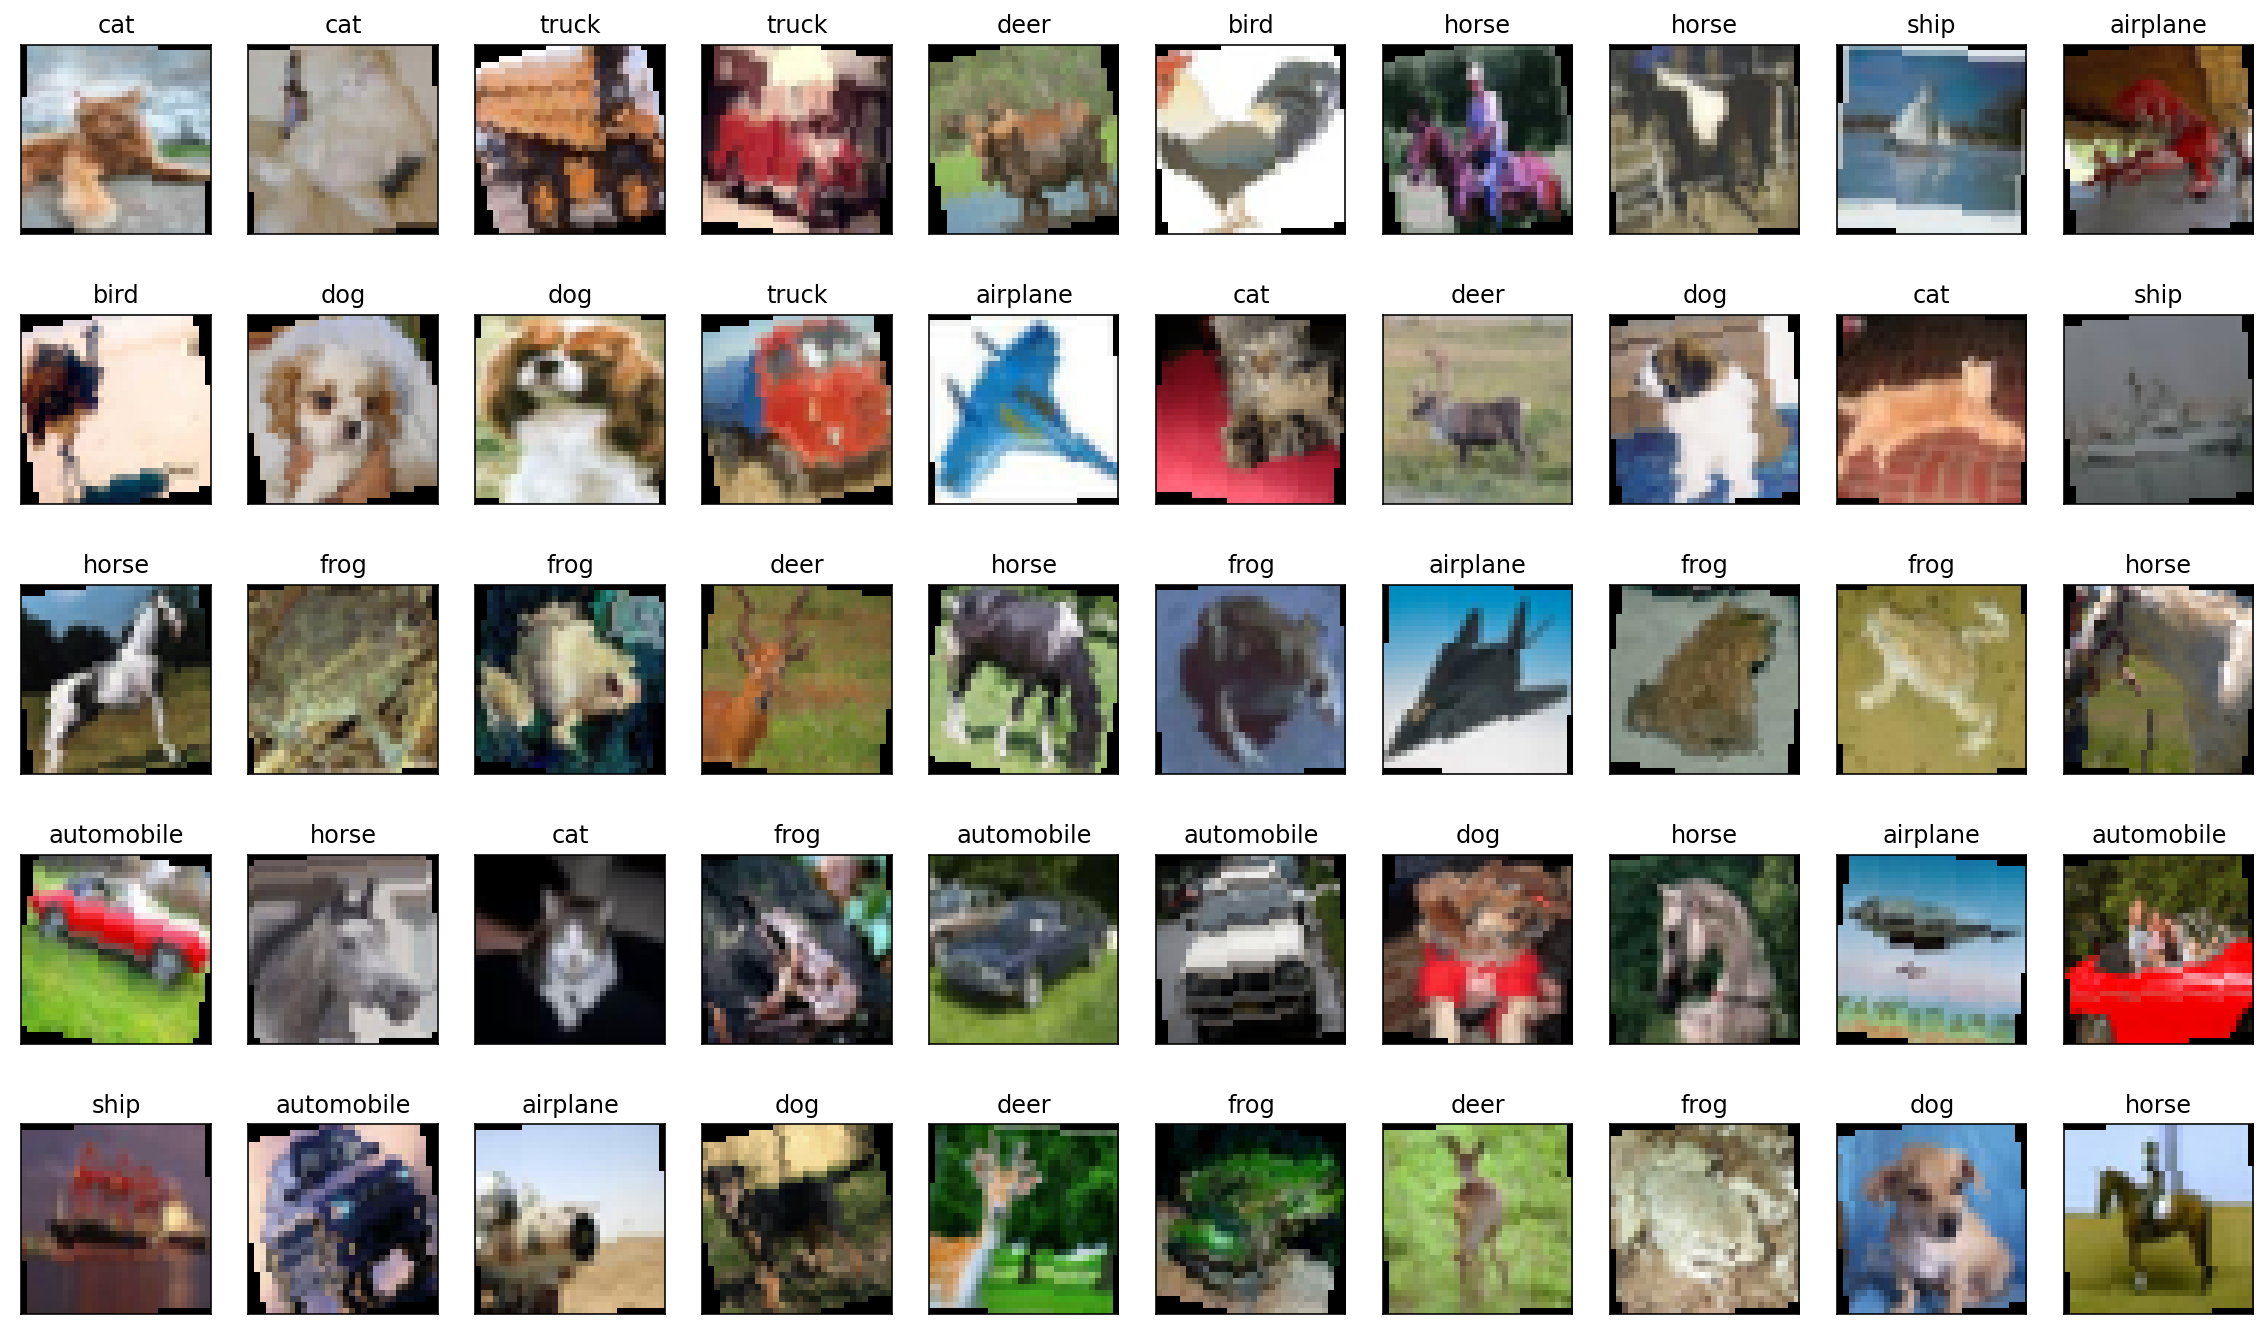

In [14]:
# Plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 12))

for idx in np.arange(50):
    ax = fig.add_subplot(5, 50/5, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### View an Image in More Detail

Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

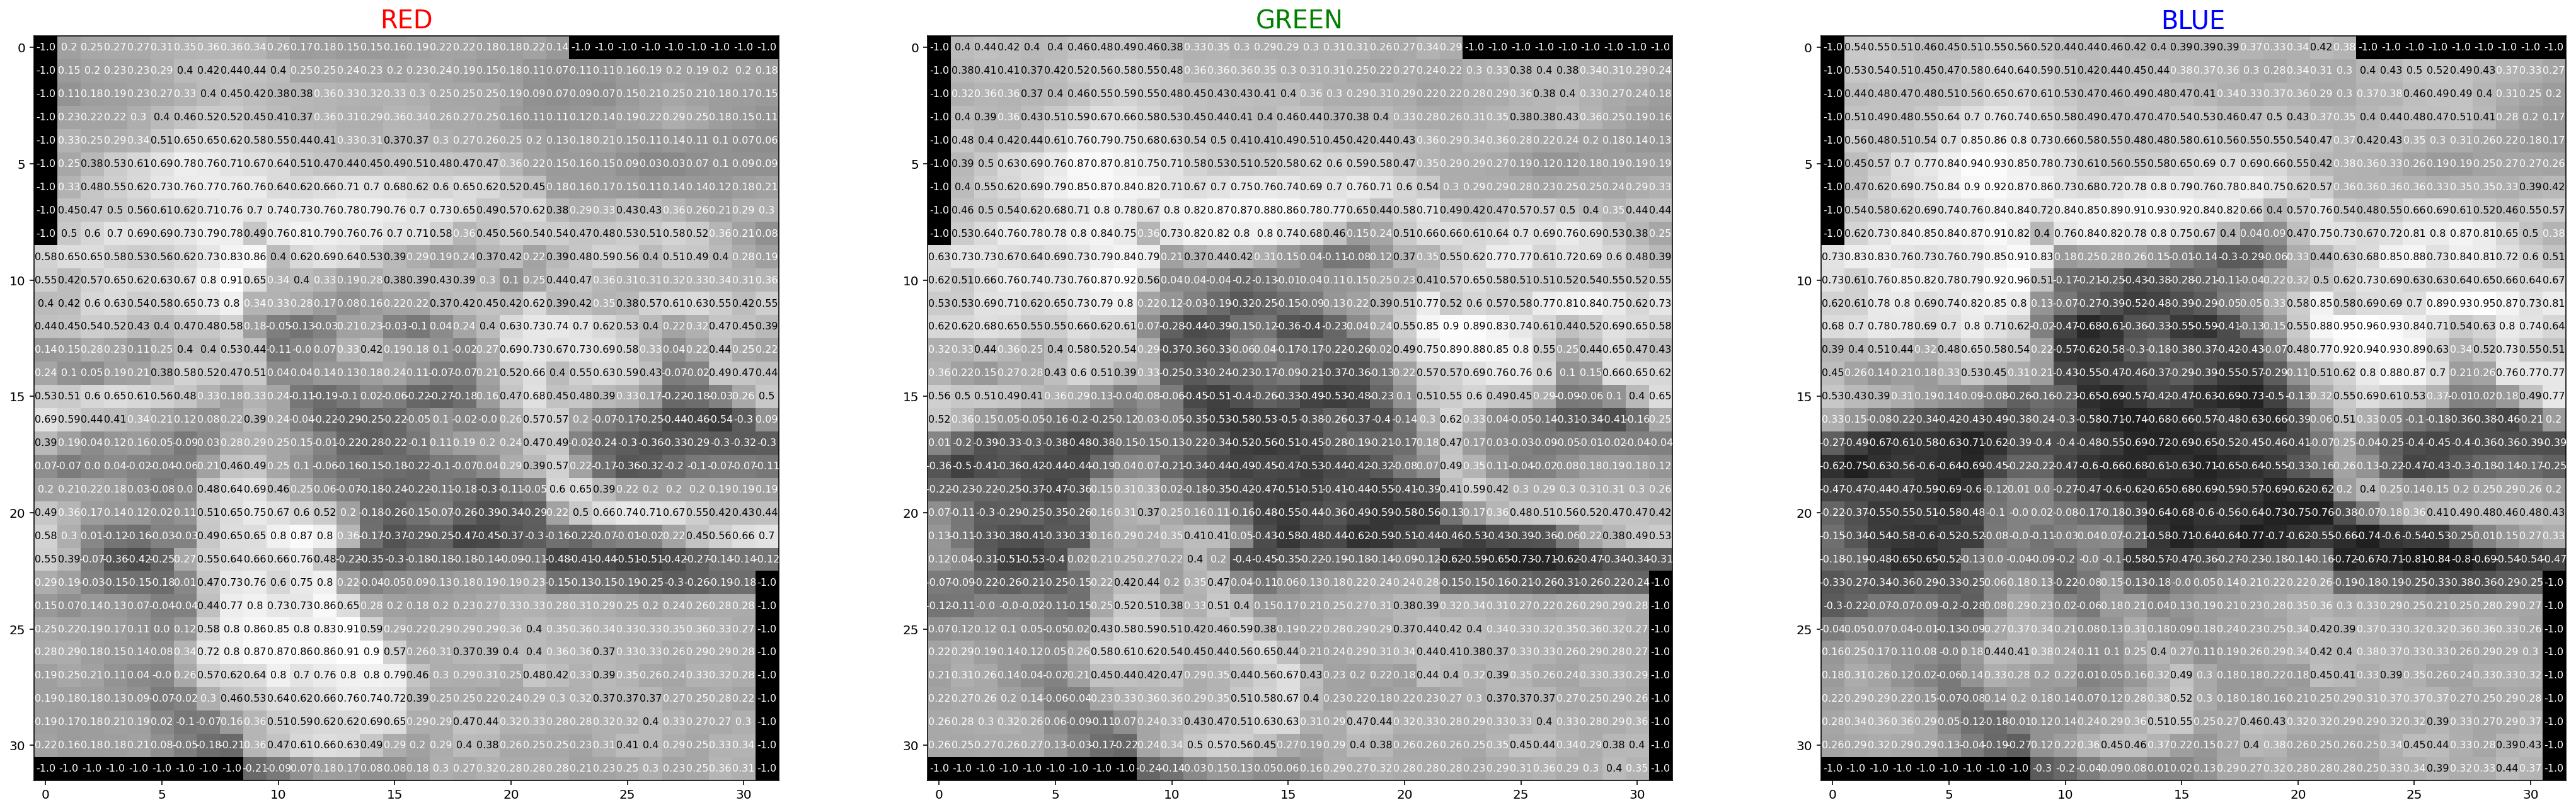

In [15]:
rgb_img = np.squeeze(images[0])
channels = ['RED', 'GREEN', 'BLUE']

fig = plt.figure(figsize = (36, 36))

for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx], size=20, color=channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y], 2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

---
## Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)

This time, you'll define a CNN architecture. Instead of an MLP, which used linear, fully-connected layers, you'll use the following:
* [Convolutional layers](https://pytorch.org/docs/stable/nn.html#conv2d), which can be thought of as stack of filtered images.
* [Maxpooling layers](https://pytorch.org/docs/stable/nn.html#maxpool2d), which reduce the x-y size of an input, keeping only the most _active_ pixels from the previous layer.
* The usual Linear + Dropout layers to avoid overfitting and produce a 10-dim output.

A network with 2 convolutional layers is shown in the image below:

<img src='notebook_ims/2_layer_conv.png' height=50% width=50% />

The more convolutional layers you include, the more complex patterns in color and shape a model can detect. It's suggested that your final model include 2 or 3 convolutional layers as well as linear layers + dropout in between to avoid overfitting. 

It's good practice to look at existing research and implementations of related models as a starting point for defining your own models. You may find it useful to look at [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) or [this, more complex Keras example](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py) to help decide on a final structure.

#### Output volume for a convolutional layer

To compute the output size of a given convolutional layer we can perform the following calculation (taken from [Stanford's cs231n course](http://cs231n.github.io/convolutional-networks/#layers)):
> We can compute the spatial size of the output volume as a function of the input volume size (W), the kernel/filter size (F), the stride with which they are applied (S), and the amount of zero padding used (P) on the border. The correct formula for calculating how many neurons define the output_W is given by `(W−F+2P)/S+1`. 

For example for a 7x7 input and a 3x3 filter with stride 1 and pad 0 we would get a 5x5 output. With stride 2 we would get a 3x3 output.

In [16]:
# Define the CNN architecture
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        
        # Max-pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64*4*4, 500)
        self.fc2 = nn.Linear(500, 250)
        self.fc3 = nn.Linear(250, 10)
        
        # Defining dropout
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        
        # Sequence of convolutional and max-pooling layers
        x = self.pool(F.relu(self.conv1(x)))      # Output size: 16, 16, 16
        x = self.pool(F.relu(self.conv2(x)))      # Output size: 32, 8, 8
        x = self.pool(F.relu(self.conv3(x)))      # Output size: 64, 4, 4
        
        # flatten image input
        x = x.view(-1, 64*4*4)
        
        # Add 1st and 2nd linear layers, with relu activation function
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))

        # Final linear layer
        x = self.fc3(x)
        
        return x

In [17]:
# Initialize the Network
model = Network()
print(model)

Network(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=250, bias=True)
  (fc3): Linear(in_features=250, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

Decide on a loss and optimization function that is best suited for this classification task. The linked code examples from above, may be a good starting point; [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) or [this, more complex Keras example](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py). Pay close attention to the value for **learning rate** as this value determines how your model converges to a small error.

In [18]:
# Specify loss function
criterion = nn.CrossEntropyLoss()

# Specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.02)

---
## Train the Network

The steps for training/learning from a batch of data are described in the comments below:
1. Clear the gradients of all optimized variables
2. Forward pass: compute predicted outputs by passing inputs to the model
3. Calculate the loss
4. Backward pass: compute gradient of the loss with respect to model parameters
5. Perform a single optimization step (parameter update)
6. Update average training loss

Remember to look at how the training and validation loss decreases over time; if the validation loss ever increases it indicates possible overfitting.

In [19]:
# Defining train function
def train(model, train_loader, valid_loader, params, save_path, print_loss=True):
    
    # Moving the model to GPU if possible
    model.to(device)
    
    # Define Settings
    criterion = params['criterion']
    optimizer = params['optimizer']
    epochs = params['epochs']
    
    # Initialize tracker for minimum validation loss
    valid_loss_min = np.Inf    # set initial "min" to infinit

    # Training the model
    train_losses, valid_losses = [], []

    for epoch in range(epochs):
        ###################
        #  Training Pass  #
        ###################
        train_loss = 0.0
        for images, labels in train_loader:
        
            # Move images & labels to GPU
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            scores = model.forward(images)
            loss = criterion(scores, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        else:
            ###################
            # Validation Pass #
            ###################
            valid_loss = 0.0
            
            # Turn off gradients for validation, saves memory and computations
            with torch.no_grad():
                # set model to evaluation mode
                model.eval()
            
                for images, labels in valid_loader:
                    # Move images & labels to GPU
                    images, labels = images.to(device), labels.to(device)
            
                    scores = model.forward(images)
                    loss = criterion(scores, labels)
                    valid_loss += loss.item()   
    
            # Calculate average loss over an epoch
            train_loss = train_loss/len(train_loader)
            valid_loss = valid_loss/len(valid_loader)
    
            # Append train and valid losses
            train_losses.append(train_loss)
            valid_losses.append(valid_loss)
    
            # Print training statistics
            if print_loss:
                print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch+1, train_loss, valid_loss))
    
            # Save model if validation loss has decreased
            if valid_loss <= valid_loss_min:
                if print_loss:
                    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_loss))
                torch.save(model.state_dict(), save_path)
                valid_loss_min = valid_loss

        # Saving losses
        losses = {'train_losses': train_losses, 'valid_losses': valid_losses}
    
        # set model back to train mode
        model.train()
        
    return losses

In [20]:
# Training the model with 50 epochs
learning_rate = 0.05
params = {'epochs': 50,
          'criterion': nn.CrossEntropyLoss(),
          'optimizer': optim.SGD(model.parameters(), lr=learning_rate)}

losses = train(model, train_loader, valid_loader, params, save_path='model_cifar.pth', print_loss=1)

Epoch: 1 	Training Loss: 2.082423 	Validation Loss: 1.719131
Validation loss decreased (inf --> 1.719131).  Saving model ...
Epoch: 2 	Training Loss: 1.614489 	Validation Loss: 1.463287
Validation loss decreased (1.719131 --> 1.463287).  Saving model ...
Epoch: 3 	Training Loss: 1.423421 	Validation Loss: 1.345027
Validation loss decreased (1.463287 --> 1.345027).  Saving model ...
Epoch: 4 	Training Loss: 1.293784 	Validation Loss: 1.191782
Validation loss decreased (1.345027 --> 1.191782).  Saving model ...
Epoch: 5 	Training Loss: 1.197239 	Validation Loss: 1.115989
Validation loss decreased (1.191782 --> 1.115989).  Saving model ...
Epoch: 6 	Training Loss: 1.124352 	Validation Loss: 1.034605
Validation loss decreased (1.115989 --> 1.034605).  Saving model ...
Epoch: 7 	Training Loss: 1.053906 	Validation Loss: 0.946644
Validation loss decreased (1.034605 --> 0.946644).  Saving model ...
Epoch: 8 	Training Loss: 0.988849 	Validation Loss: 0.948533
Epoch: 9 	Training Loss: 0.939533 

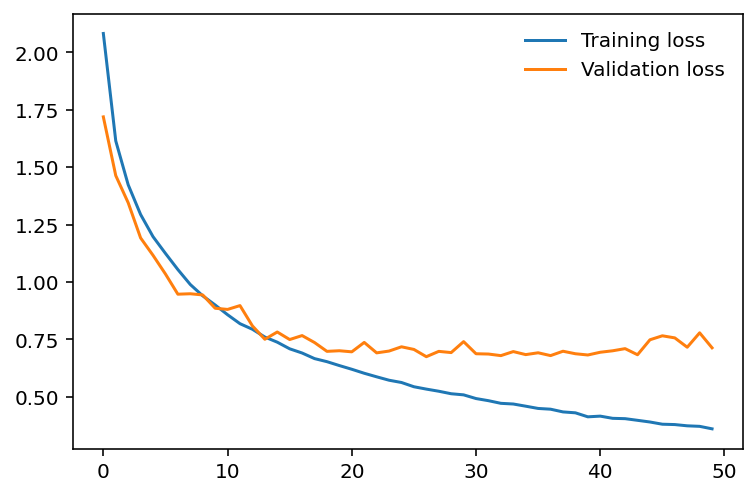

In [21]:
# Displaying Training and Validation losses
train_losses = losses['train_losses']
valid_losses = losses['valid_losses']

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False);

###  Load the Model with the Lowest Validation Loss

In [22]:
model.load_state_dict(torch.load('model_cifar.pth'))

<All keys matched successfully>

---
## Test the Trained Network

Finally, we test our best model on previously unseen **test data** and evaluate it's performance. Testing on unseen data is a good way to check that our model generalizes well. It may also be useful to be granular in this analysis and take a look at how this model performs on each class as well as looking at its overall loss and accuracy.

#### `model.eval()`

`model.eval(`) will set all the layers in your model to evaluation mode. This affects layers like dropout layers that turn "off" nodes during training with some probability, but should allow every node to be "on" for evaluation!

In [27]:
# Defining test function
def test(model, test_loader):
    # Moving the model to GPU if possible
    model.to(device)
    
    # Initialize lists to monitor test loss and accuracy
    test_loss = 0.0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    # Turn off gradients for validation, saves memory and computations
    with torch.no_grad():
        # set model to evaluation mode
        model.eval()

        for images, labels in test_loader:
            # Move images & labels to GPU
            images, labels = images.to(device), labels.to(device)

            scores = model.forward(images)
            loss = criterion(scores, labels)
            test_loss += loss.item()
        
            # Compare predictions to true labels
            top_p, top_class = torch.max(scores, 1)
            correct = np.squeeze(top_class.eq(labels.data.view_as(top_class)))
        
            # Calculate test accuracy for each object class
            for i in range(len(labels)):
                label = labels.data[i]
                class_correct[label] += correct[i].item()
                class_total[label] += 1


        # Calculate and print avg test loss
        test_loss = test_loss/len(test_loader)
        print('Test Loss: {:.6f}\n'.format(test_loss))

        for i in range(10):
            if class_total[i] > 0:
                print('Test Accuracy of {}:   \t{:.2%} ({}/{})'.format(classes[i], class_correct[i] / class_total[i],
                                                                int(np.sum(class_correct[i])), int(np.sum(class_total[i]))))
            else:
                print('Test Accuracy of {}: N/A (no training examples)'.format(classes[i]))

        print('\nTest Accuracy (Overall): {:.2%}\t ({}/{})'.format(np.sum(class_correct) / np.sum(class_total),
                                                            int(np.sum(class_correct)), int(np.sum(class_total))))

In [28]:
# Testing the model
test(model, test_loader)

Test Loss: 0.666158

Test Accuracy of airplane:   	83.50% (835/1000)
Test Accuracy of automobile:   	86.40% (864/1000)
Test Accuracy of bird:   	64.20% (642/1000)
Test Accuracy of cat:   	59.70% (597/1000)
Test Accuracy of deer:   	72.60% (726/1000)
Test Accuracy of dog:   	65.20% (652/1000)
Test Accuracy of frog:   	87.70% (877/1000)
Test Accuracy of horse:   	86.40% (864/1000)
Test Accuracy of ship:   	88.90% (889/1000)
Test Accuracy of truck:   	84.10% (841/1000)

Test Accuracy (Overall): 77.87%	 (7787/10000)


**Note**: This model seems to do best on vehicles rather than animals. For example, it does best on the ship class and worst on the cat class. I suspect it's because animals vary in color and size and so it would improve this model if I could increase the number of animal images in the first place or perhaps if I added another convolutional layer to detect finer patterns in these images. I could also experiment with a smaller learning rate so that the model takes small steps in the right direction as it is training.

### Visualize Sample Test Results

This cell displays test images and their labels in this format: `predicted (ground-truth)`. The text will be green for accurately classified examples and red for incorrect predictions.

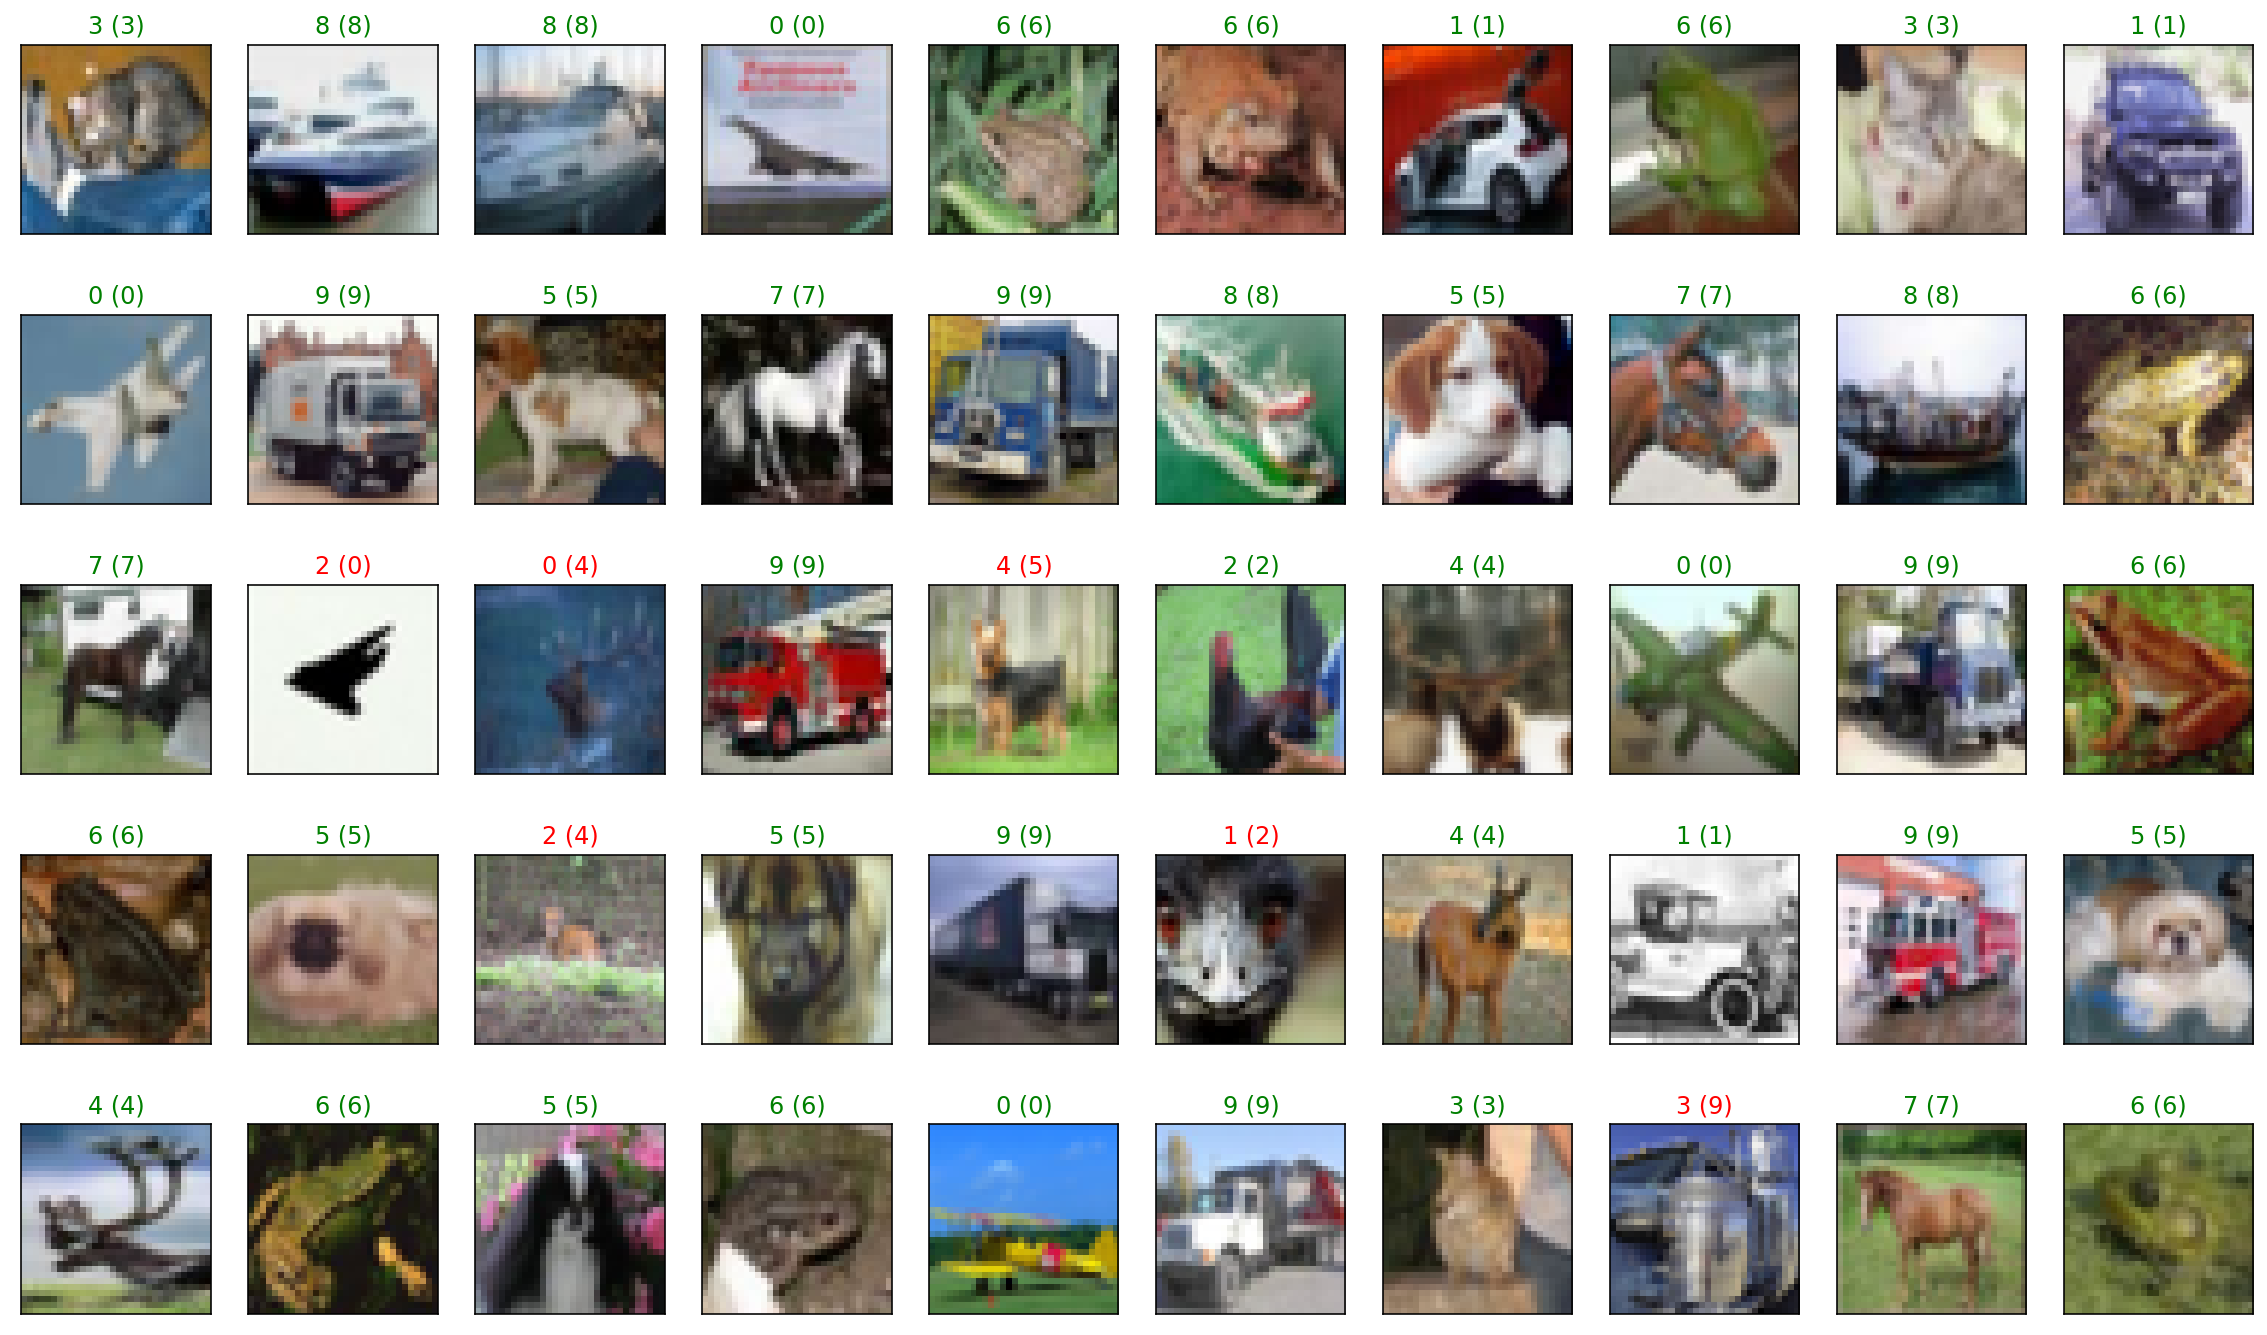

In [31]:
# Obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# Move images & labels to GPU
images, labels = images.to(device), labels.to(device)

# Get sample outputs
scores = model.forward(images)

# Compare predictions to true labels
top_p, top_class = torch.max(scores, 1)

# Prep images for display
images = images.cpu().numpy()
labels = labels.cpu().numpy()
top_class = top_class.cpu().numpy()

# Plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(20, 12))

for idx in np.arange(50):
    ax = fig.add_subplot(5, 50/5, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title("{} ({})".format(str(top_class[idx].item()), str(labels[idx].item())),
                 color=("green" if top_class[idx]==labels[idx] else "red"))